In [2]:
import os
import argparse
import scipy.io
import scipy.misc
import PIL
import numpy as np
import pandas as pd
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model

from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image
%matplotlib inline

In [3]:
# Implementing boxes and filtering by threshold on object and class confidence

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.65):
    box_scores = box_class_probs * box_confidence
    box_classes = tf.math.argmax(box_scores, axis = -1)
    box_class_scores = tf.math.reduce_max(box_scores, axis = -1)
    filtering_mask = (box_class_scores >= threshold)
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [4]:
# implement intersection over union to keep box with highest probability only

def intersection_over_union(box_1, box_2):
    
    (box1_x1, box1_y1, box1_x2, box1_y2) = box_1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box_2
    
    x_i1 = max(box1_x1, box2_x1)
    y_i1 = max(box1_y1, box2_y1)
    x_i2 = max(box1_x2, box2_x2)
    y_i2 = max(box1_y2, box2_y2)
    intersection_width = max(0, y_i2 - y_i1)
    intersection_height = max(0, x_i2 - x_i1)
    intersection_area = intersection_width * intersection_height
    
    box1_area = (box1_x2 - box1_x1) * ((box1_y2 - box1_y1))
    box2_area = (box2_x2 - box2_x1) * ((box2_y2 - box2_y1))
    union_area = box1_area * box2_area - intersection_area
    
    intersection_over_union = intersection_area / union_area
    
    return intersection_over_union

In [5]:
# compute the box overlap and keep box with highest score

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 20, int_over_union_threshold = 0.6):
    max_boxes_tensor = tf.Variable(max_boxes, dtype = 'int32')
    box_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, int_over_union_threshold)
    
    scores = tf.gather(scores, box_indices)
    boxes = tf.gather(boxes, box_indices)
    classes = tf.gather(classes, box_indices)
    
    return scores, boxes, classes

In [6]:
# getting box coordinates to fit the yolo model input

def yolo_boxes_to_corners(box_xy, box_wh):
    min_box = box_xy - (box_wh / 2.)
    max_box = box_xy + (box_wh / 2.)
    
    return tf.keras.backend.concatenate([
        min_box[..., 1:2],
        min_box[..., 0:1],
        max_box[..., 1:2],
        max_box[..., 0:1]
    ])

In [7]:
# converts Yolo output to predicted boxes, scores, coordinates and classes

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes = 20, score_threshold = 0.65, int_over_union_threshold = 0.6):
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, int_over_union_threshold)
    
    return scores, boxes, classes

In [8]:
# defining anchor boxes and class names

class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)

In [9]:
# load model
yolo_model = load_model("model_data/", compile = False)

In [10]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalizati

In [11]:
# predict boxes for image

def predict(image_file):
    # Preprocess your image
    image, image_data = preprocess_image("../images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "../images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("../out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("../out", image_file))
    plt.axis('off')
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 3 boxes for ../images/0023.jpg
car 0.42 (161, 324) (204, 344)
car 0.36 (541, 298) (566, 314)
car 0.31 (213, 316) (245, 337)


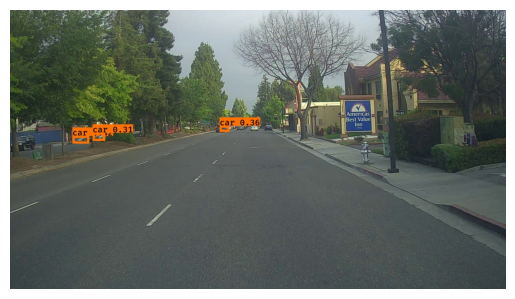

In [12]:
# predict on same image
out_scores, out_boxes, out_classes = predict("0023.jpg")

Found 10 boxes for ../images/traffimg.jpg
car 0.79 (605, 480) (863, 595)
car 0.73 (467, 326) (597, 434)
car 0.71 (205, 410) (484, 571)
car 0.71 (229, 305) (332, 379)
truck 0.70 (876, 110) (1200, 434)
car 0.67 (284, 370) (408, 442)
motorbike 0.55 (3, 436) (78, 504)
car 0.54 (387, 328) (462, 402)
car 0.52 (532, 302) (624, 364)
car 0.45 (370, 308) (467, 377)


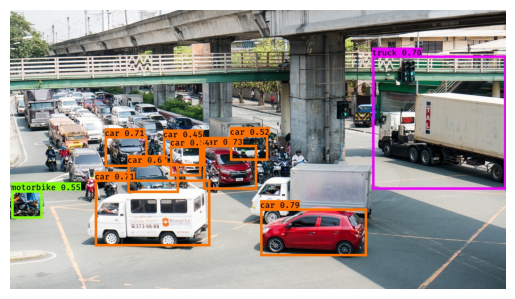

In [13]:
out_scores, out_boxes, out_classes = predict("traffimg.jpg")